# Energy Consumption Classification

This notebook processes energy consumption data from the selected household appliances and gives the prediction for lower cost

## Project Structure:
- **csv_file/**: Contains the raw energy consumption data
- **notebooks/**: Jupyter notebooks for analysis
- **output/**: Processed data and results
- **src/**: Source code modules


In [36]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


print("Successfully imported!")

Successfully imported!


## Step 1: Load and print the basic information of the dataset

First, let's load the CSV file with selected appliances and the energy consumption for every minute and check the information of the dataset

In [37]:
df = pd.read_csv('../csv_file/house1_2013_1min-kopi.csv')
#print("The first 5 rows", df.head())
#print("The last 5 rows", df.tail())

print(f'Complete shape of the file: {df.shape}')

#checking any timestamp columns available in the dataset
timestamp_cols = [col for col in df.columns if any(word in col.lower() for word in ['time', 'date','timestamp','datetime'])]
print(f'Time stamp columns exits: {timestamp_cols}')

#if first column looks like timestamp,
if len(timestamp_cols) == 0 and df.shape[1]>1:
    timestamp_cols = [df.columns[0]]
    print(f'Assuming the first column is timestamp: {timestamp_cols}')

#Display some basic info about the dataset
print(f'\nFile info:')
print(f' - Shape: {df.shape}')
print(f' - Columns: {len(df.columns)}')
print(f' - Memory_usage: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB')

Complete shape of the file: (525600, 25)
Time stamp columns exits: ['timestamp']

File info:
 - Shape: (525600, 25)
 - Columns: 25
 - Memory_usage: 134.34 MB


### Step 2: Parse Timestamps and Prepare for Hourly Aggregation

Converting the timestamp column to datetime and prepare the data for hourly aggregation

In [38]:
df_processed = df.copy()

if timestamp_cols:
    timestamp_col = timestamp_cols[0]
else:
    timestamp_col = df.columns[0]

print(f'The column used as timestamp: {timestamp_col}')
print(f'Timestamp values: {df_processed[timestamp_col].head().tolist()}')

#convert the timestamp column to datetime
df_processed[timestamp_col] = pd.to_datetime(df_processed[timestamp_col])

df_processed.set_index(timestamp_col, inplace=True)

#find all columns that has numeric values (floats or int)
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
print(f'`n Numeric columns (Appliances): {len(numeric_cols)}')
print(f'Appliances Names: {numeric_cols[:10]}..')

#Display the time range of your data
print(f'\n Data time range:')
print(f' - Start:{df_processed.index.min()}')
print(f' - End:{df_processed.index.max()}')
print(f' - Duration: {df_processed.index.max() - df_processed.index.min()}')

The column used as timestamp: timestamp
Timestamp values: ['2013-01-01 00:00:00', '2013-01-01 00:01:00', '2013-01-01 00:02:00', '2013-01-01 00:03:00', '2013-01-01 00:04:00']
`n Numeric columns (Appliances): 24
Appliances Names: ['aggregate', 'washing_machine', 'dishwasher', 'tv', 'kitchen_lights', 'htpc', 'kettle', 'toaster', 'microwave', 'amp_livingroom']..

 Data time range:
 - Start:2013-01-01 00:00:00
 - End:2013-12-31 23:59:00
 - Duration: 364 days 23:59:00
`n Numeric columns (Appliances): 24
Appliances Names: ['aggregate', 'washing_machine', 'dishwasher', 'tv', 'kitchen_lights', 'htpc', 'kettle', 'toaster', 'microwave', 'amp_livingroom']..

 Data time range:
 - Start:2013-01-01 00:00:00
 - End:2013-12-31 23:59:00
 - Duration: 364 days 23:59:00


## Step 3: Create hourly aggregated data for individual appliance

Now we'll aggregate the 1-minute intervals to hourly intervals and create separate columns for each appliance alongside the total consumption.

In [39]:
hourly_interval = df_processed.resample('h').sum()
print(f'Hourly interval shape: {hourly_interval.shape}')
print(f'Time range after aggregation:')
print(f' - Start: {hourly_interval.index.min()}')
print(f' - End: {hourly_interval.index.max()}')
print(f' - Total hours: {len(hourly_interval)}')

#compute total appliance consumption
hourly_interval['Total_consumption'] = hourly_interval[numeric_cols].sum(axis=1)
print(f'Columns after adding total consumption:{hourly_interval.columns.tolist()}')

#reorder the columns
cols = ['Total_consumption'] + [col for col in hourly_interval.columns if col !='Total_consumption']
hourly_interval = hourly_interval[cols]
print(f'\n Hourly Interval with total consumption:')
print(f'- Shape: {hourly_interval.shape}')
print(f'- Columns: {len(hourly_interval.columns)} (1 total + {len(numeric_cols)} individual appliances)')
print(f'\n First 5 rows of hourly data: {hourly_interval.head()}')
#print(f'\n Basic description of total consumption: {hourly_interval["Total_consumption"].describe()}')

Hourly interval shape: (8760, 24)
Time range after aggregation:
 - Start: 2013-01-01 00:00:00
 - End: 2013-12-31 23:00:00
 - Total hours: 8760
Columns after adding total consumption:['aggregate', 'washing_machine', 'dishwasher', 'tv', 'kitchen_lights', 'htpc', 'kettle', 'toaster', 'microwave', 'amp_livingroom', 'livingroom_s_lamp', 'kitchen_dt_lamp', 'bedroom_ds_lamp', 'livingroom_s_lamp2', 'subwoofer_livingroom', 'livingroom_lamp_tv', 'kitchen_lamp2', 'utilityrm_lamp', 'bedroom_d_lamp', 'childs_table_lamp', 'childs_ds_lamp', 'office_lamp1', 'office_lamp2', 'office_lamp3', 'Total_consumption']

 Hourly Interval with total consumption:
- Shape: (8760, 25)
- Columns: 25 (1 total + 24 individual appliances)

 First 5 rows of hourly data:                      Total_consumption  aggregate  washing_machine  \
timestamp                                                            
2013-01-01 00:00:00          65279.684  35900.752              0.0   
2013-01-01 01:00:00          61361.493  33727

## Step 4: Data Analysis and Visualization

Let's analyze the energy consumption patterns and visualize the data.

Top 10 energy-consuming appliances:
aggregate          1.962377e+08
kitchen_lights     1.362247e+07
washing_machine    1.238960e+07
htpc               9.102502e+06
dishwasher         8.260295e+06
toaster            8.212208e+06
kettle             8.049403e+06
utilityrm_lamp     6.637450e+06
tv                 5.637625e+06
microwave          2.964625e+06
dtype: float64


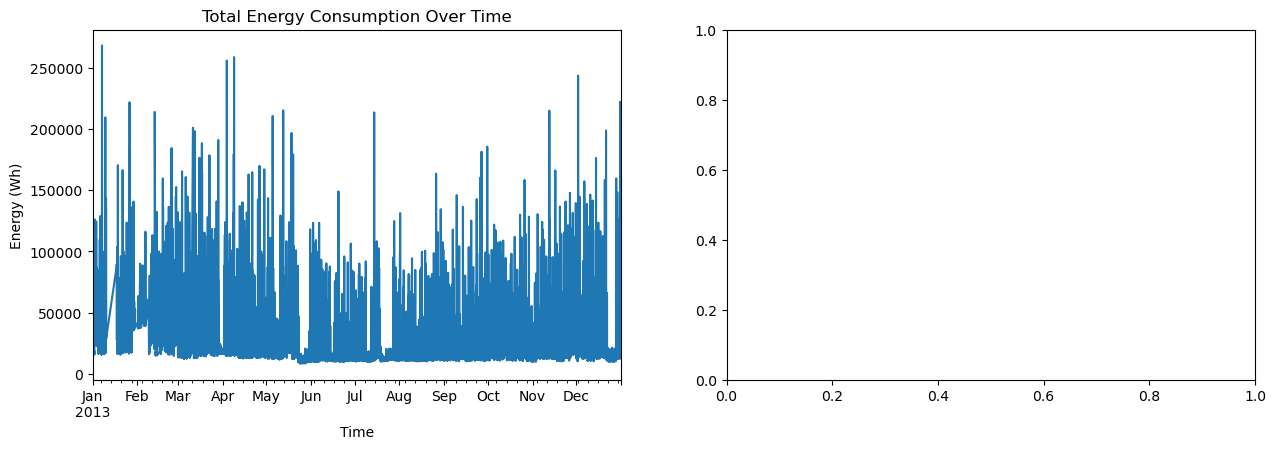

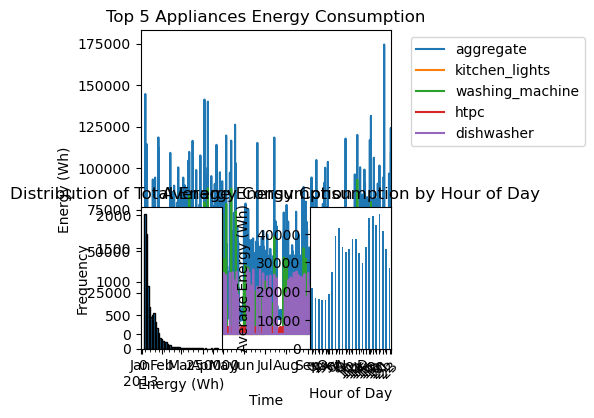

In [40]:
# Analyze energy consumption patterns
# Top 10 energy-consuming appliances
    
appliance_totals = hourly_interval[numeric_cols].sum().sort_values(ascending=False)
print("Top 10 energy-consuming appliances:")
print(appliance_totals.head(10))
    
# Create visualizations
plt.figure(figsize=(15, 10))
    
# Plot 1: Total consumption over time
plt.subplot(2, 2, 1)
hourly_interval['Total_consumption'].plot()
plt.title('Total Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy (Wh)')
    
# Plot 2: Top 5 appliances consumption over time
plt.subplot(2, 2, 2)
top_5_appliances = appliance_totals.head(5).index
hourly_interval[top_5_appliances].plot()
plt.title('Top 5 Appliances Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy (Wh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
# Plot 3: Distribution of total consumption
plt.subplot(2, 2, 3)
plt.hist(hourly_interval['Total_consumption'], bins=50, edgecolor='black')
plt.title('Distribution of Total Energy Consumption')
plt.xlabel('Energy (Wh)')
plt.ylabel('Frequency')
    
# Plot 4: Hourly pattern (average consumption by hour of day)
plt.subplot(2, 2, 4)
hourly_pattern = hourly_interval.groupby(hourly_interval.index.hour)['Total_consumption'].mean()
hourly_pattern.plot(kind='bar')
plt.title('Average Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy (Wh)')
plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()
    


## Step 5: Save the Processed Data

Save the hourly aggregated data to a new CSV file for further analysis.

In [41]:
# Save the processed hourly data
output_path = '../csv_file'
os.makedirs(output_path, exist_ok = True)
output_file = os.path.join(output_path, 'house1_hourly_2013.csv')

#make timestamp as a normal column
hourly_interval_to_save = hourly_interval.reset_index()
hourly_interval_to_save.to_csv(output_file, index=False) 
print(f'Hourly consumption data is saved to: {output_file}')
print(f'File size: {os.path.getsize(output_file)/ 1024 **2:.2f} MB')
print(f'Shape {hourly_interval_to_save.shape}')

summary_file = os.path.join(output_path, "summary_appliance.csv")

summary_df = pd.DataFrame({
    'Appliance': appliance_totals.index,
    'Total_Energy_wh': appliance_totals.values,
    'Avg_Hourly_Energy_Wh': appliance_totals.values / len(hourly_interval),
    'Percentage_of_Total': (appliance_totals.values / appliance_totals.sum()) * 100
}) 
    
summary_df.to_csv(summary_file, index=False)
print(f"Appliance summary saved to: {summary_file}")
    
# Display final structure
print(f"\nFinal dataset structure:")
print(f"- Rows (hours): {len(hourly_interval)}")
print(f"- Columns: {len(hourly_interval.columns)}")
print(f"  - Total_Consumption: 1 (aggregated)")
print(f"  - Individual appliances: {len(numeric_cols)}")
    
print(f"\nColumn names:")
print(hourly_interval.columns.tolist()[:10])  # Show first 10 columns
if len(hourly_interval.columns) > 10:
    print(f"... and {len(hourly_interval.columns) - 10} more")
    


Hourly consumption data is saved to: ../csv_file\house1_hourly_2013.csv
File size: 1.41 MB
Shape (8760, 26)
Appliance summary saved to: ../csv_file\summary_appliance.csv

Final dataset structure:
- Rows (hours): 8760
- Columns: 25
  - Total_Consumption: 1 (aggregated)
  - Individual appliances: 24

Column names:
['Total_consumption', 'aggregate', 'washing_machine', 'dishwasher', 'tv', 'kitchen_lights', 'htpc', 'kettle', 'toaster', 'microwave']
... and 15 more


## Step 6: Prepare Data for Classification

Now let's prepare the data for classification tasks by creating features and target variables.

In [42]:
# Prepare data for classification
try:
    # Create classification features
    classification_data = hourly_interval.copy()
    
    # Add time-based features
    classification_data['Hour'] = classification_data.index.hour
    classification_data['DayOfWeek'] = classification_data.index.dayofweek
    classification_data['Month'] = classification_data.index.month
    classification_data['IsWeekend'] = (classification_data.index.dayofweek >= 5).astype(int)
    
    # Create consumption level categories for classification
    # Define consumption levels based on quantiles
    consumption_quantiles = classification_data['Total_consumption'].quantile([0.25, 0.5, 0.75])
    
    def categorize_consumption(value):
        if value <= consumption_quantiles[0.25]:
            return 'Low'
        elif value <= consumption_quantiles[0.5]:
            return 'Medium-Low'
        elif value <= consumption_quantiles[0.75]:
            return 'Medium-High'
        else:
            return 'High'
    
    classification_data['Consumption_Category'] = classification_data['Total_Consumption'].apply(categorize_consumption)
    
    print("Classification categories created:")
    print(classification_data['Consumption_Category'].value_counts())
    
    print(f"\nQuantile thresholds:")
    print(f"Low: <= {consumption_quantiles[0.25]:.2f} Wh")
    print(f"Medium-Low: <= {consumption_quantiles[0.5]:.2f} Wh") 
    print(f"Medium-High: <= {consumption_quantiles[0.75]:.2f} Wh")
    print(f"High: > {consumption_quantiles[0.75]:.2f} Wh")
    
    # Save classification-ready data
    classification_file = os.path.join(output_path, "classification_ready_data.csv")
    classification_data_to_save = classification_data.reset_index()
    classification_data_to_save.to_csv(classification_file, index=False)
    
    print(f"\nClassification-ready data saved to: {classification_file}")
    print(f"Shape: {classification_data_to_save.shape}")
    
    # Display sample of the final data
    print(f"\nSample of classification-ready data:")
    print(classification_data[['Total_consumption', 'Hour', 'DayOfWeek', 'IsWeekend', 'Consumption_Category']].head(10))
    
except Exception as e:
    print(f"Error preparing classification data: {e}")

Error preparing classification data: 'Total_Consumption'
